In [99]:

import pandas as pd
from pandas import factorize
import numpy as np
import warnings

import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, log_loss, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(10,5)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split

import optuna
import optuna.visualization as vis
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [198]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)

Text(0.5, 1.0, 'Test Dataset: Missing Values')

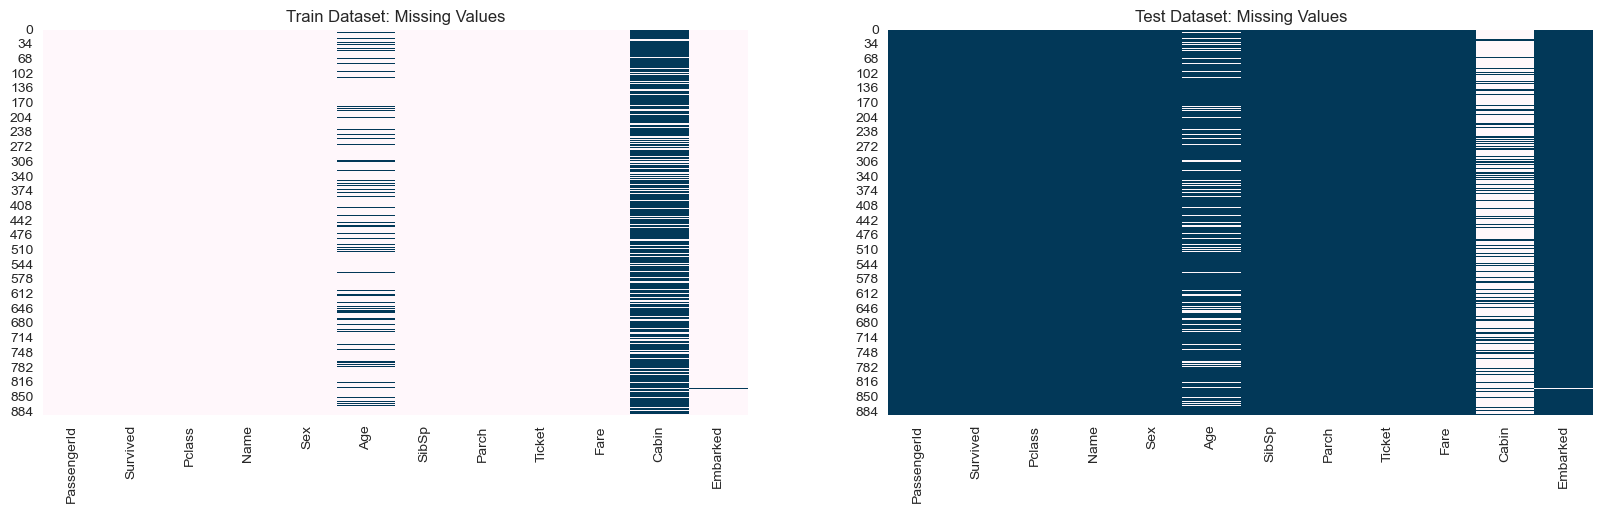

In [199]:
##lets check null value in both datasets
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu',ax=ax[0])
ax[0].set_title('Train Dataset: Missing Values')
sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu_r',ax=ax[1])
ax[1].set_title('Test Dataset: Missing Values')

In [200]:
# Show missing values for the entire dataset
def missing_tbl(df):
    tbl = pd.DataFrame()
    
    tbl['Column'] = df.columns
    tbl['Missing'] = [df[col].isnull().sum() for col in df.columns]
    tbl['Percentage'] = [round((df[col].isnull().sum() / df.shape[0])*100, 2) for col in df.columns]
    return tbl


missing_tbl(entire_df)

,Column,Missing,Percentage
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,263,20.09
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,1,0.08


Text(0.5, 1.0, 'Age Distribution')

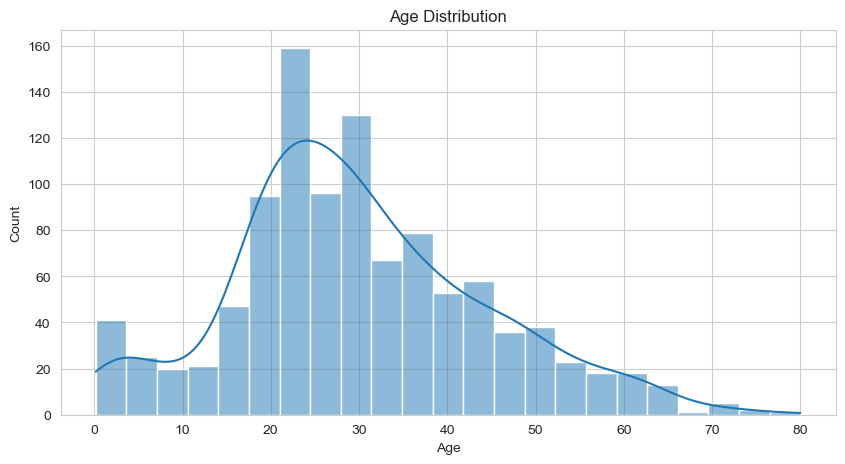

In [201]:
## age distr
sns.histplot(data=entire_df['Age'], kde=True)
plt.title('Age Distribution')

In [202]:
# Create Title column by extracting title from Name column
def create_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.split(', ', expand=True)[1]
    df['Title'] = df['Title'].str.split('.', expand=True)[0]
    return df


entire_df = create_title(entire_df)

In [203]:
# Standardized Title column
def standardized_title(df):
    df = df.copy()
    
    # Unmarried woman
    unmarried_w = ['Mlle', 'Ms']
    for uw in unmarried_w:
        df['Title'].replace({uw : 'Miss'}, inplace=True)
    
    # Married woman
    married_w = ['Dona', 'Mme', 'Lady', 'the Countess']
    for mv in married_w:
        df['Title'].replace({mv : 'Mrs'}, inplace=True)
    
    # Man
    man = ['Don', 'Rev', 'Capt', 'Col', 'Major', 'Jonkheer', 'Sir']
    for m in man:
        df['Title'].replace({m : 'Mr'}, inplace=True)
        
    return df



entire_df = standardized_title(entire_df)

In [204]:
# Compute the correlation between age and title/emb
def cat_corr(feature):
    categories = ['Sex', 'Title', 'Embarked']
    print('Correlation between {} and Categorical Features:'.format(feature))
    for cat in categories:
        labels, categories = factorize(entire_df[cat])
        entire_df['labels'] = labels
        correlation = abs(entire_df[feature].corr(entire_df['labels']))
        print('{} : {:.4f}'.format(cat, correlation))
        entire_df.drop('labels', axis=1, inplace=True)
        
cat_corr('Age')

##as we can see there is title -> age correlation

Correlation between Age and Categorical Features:
Sex : 0.0636
Title : 0.3821
Embarked : 0.0424


In [205]:
# fillna age with median value
median_age = entire_df.groupby('Title')['Age'].median()
def fill_age(title, age):
    if np.isnan(age): 
        return median_age.loc[title]
    else:
        return age

    
# replace nan age with median age based on Title
entire_df['Age'] = entire_df.apply(lambda x : fill_age(x['Title'], x['Age']), axis=1)   

In [206]:
# the same with faere
def cat_corr(feature):
    categories = ['Sex', 'Title', 'Embarked', 'Pclass', 'Age']
    print('Correlation between {} and Categorical Features:'.format(feature))
    for cat in categories:
        labels, categories = factorize(entire_df[cat])
        entire_df['labels'] = labels
        correlation = abs(entire_df[feature].corr(entire_df['labels']))
        print('{} : {:.4f}'.format(cat, correlation))
        entire_df.drop('labels', axis=1, inplace=True)
        
cat_corr('Fare')

Correlation between Fare and Categorical Features:
Sex : 0.1855
Title : 0.1450
Embarked : 0.0588
Pclass : 0.1988
Age : 0.1206


In [207]:
def fill_fare(pclass, fare):
    median_fare = entire_df.groupby('Pclass')['Fare'].median()
    if np.isnan(fare):
        return median_fare.loc[pclass]
    else:
        return fare

entire_df['Fare'] = entire_df.apply(lambda x : fill_fare(x['Pclass'], x['Fare']), axis=1) 

In [208]:
entire_df['Embarked'].fillna(entire_df['Embarked'].mode()[0], inplace=True)

In [209]:
## add feature of family size
entire_df['Fam'] = entire_df['SibSp'] + entire_df['Parch'] + 1

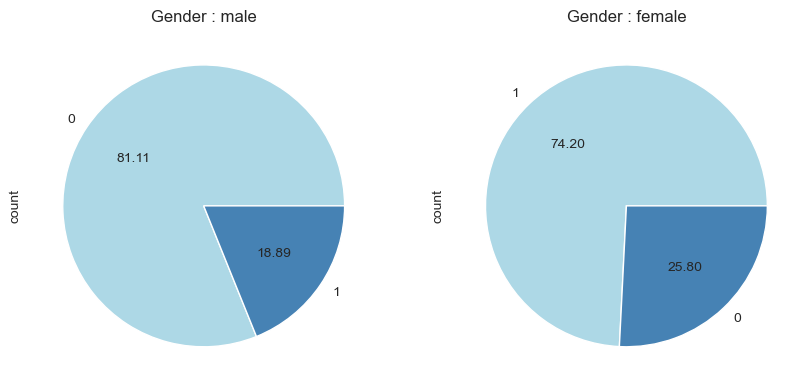

In [210]:
fig = plt.figure(figsize=(10,5))

i = 0
for gender in train_df['Sex'].unique():
    fig.add_subplot(1, 2, i+1)
    plt.title('Gender : {}'.format(gender))
    train_df.Survived[train_df['Sex'] == gender].value_counts().plot(kind='pie', autopct='%.2f', colors=['lightblue', 'steelblue'])
    i += 1

In [211]:
gender_mapping = {'male':0,
                  'female':1}

entire_df['Sex'] = entire_df['Sex'].apply(lambda x : gender_mapping.get(x))


embark_mapping = {'S':0,
                  'Q':1,
                  'C':2}

entire_df['Embarked'] = entire_df['Embarked'].apply(lambda x : embark_mapping.get(x))


title_mapping = {'Mr':0,
                 'Dr':1,
                 'Master':2,
                 'Miss':3,
                 'Mrs':4}

entire_df['Title'] = entire_df['Title'].apply(lambda x : title_mapping.get(x))

Text(0.5, 1.0, 'Fam Distribution')

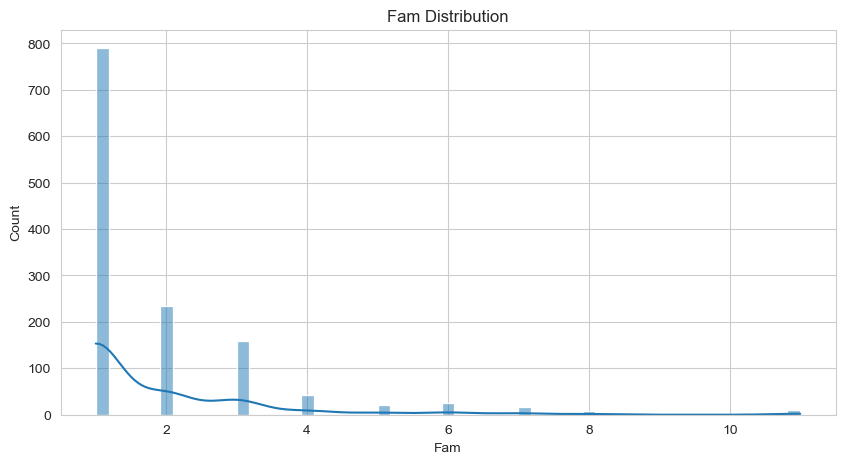

In [212]:
## fam distr
sns.histplot(data=entire_df['Fam'], kde=True)
plt.title('Fam Distribution')

In [115]:
entire_df.Fam.value_counts()

Fam
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64

In [213]:
entire_df['Fam'] = entire_df['Fam'].apply(lambda x: x if x <= 4 else 5)

In [214]:
from sklearn.preprocessing import OrdinalEncoder

features = ['Name', 'Ticket']

for feat in features:
    entire_df[feat] = OrdinalEncoder().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [215]:


features = ['Name', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Ticket','Embarked', 'Fam', 'Title']

for feat in features:
    entire_df[feat] = MinMaxScaler().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [216]:
entire_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fam
0,1,0,1.0,0.118683,0,22.0,0.125,0.000000,0.775862,0.014151,NaN,0.0,0.00,0.25
1,2,1,0.0,0.218989,1,38.0,0.125,0.000000,0.879310,0.139136,C85,1.0,1.00,0.25
2,3,1,1.0,0.400459,1,26.0,0.000,0.000000,0.984914,0.015469,NaN,0.0,0.75,0.00
3,4,1,0.0,0.323124,1,35.0,0.125,0.000000,0.070043,0.103644,C123,0.0,1.00,0.25
4,5,0,1.0,0.016845,0,35.0,0.000,0.000000,0.699353,0.015713,NaN,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,1.0,0.862175,0,30.0,0.000,0.000000,0.766164,0.015713,NaN,0.0,0.00,0.00
414,1306,1,0.0,0.682236,1,39.0,0.000,0.000000,0.898707,0.212559,C105,1.0,1.00,0.00
415,1307,0,1.0,0.800919,0,38.5,0.000,0.000000,0.939655,0.014151,NaN,0.0,0.00,0.00
416,1308,0,1.0,0.939510,0,30.0,0.000,0.000000,0.623922,0.015713,NaN,0.0,0.00,0.00


In [217]:
entire_df.drop(['Cabin'], axis=1, inplace=True)

<Axes: >

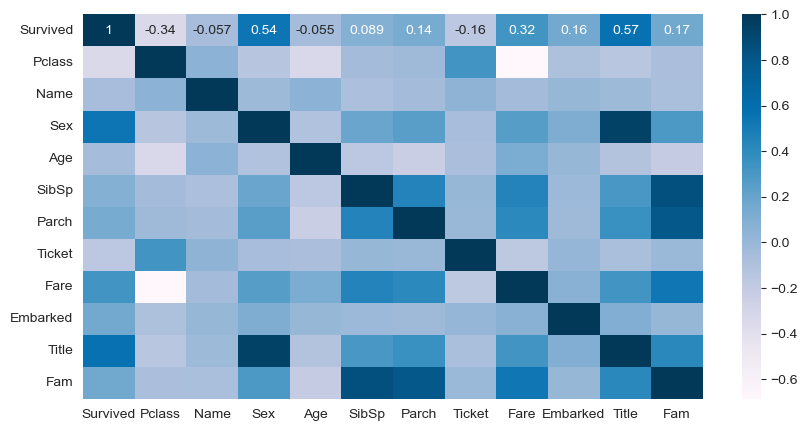

In [222]:
train_df = (entire_df.iloc[0:891][['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Title', 'Fam']]).copy()
corr_matrix = train_df.corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True, cmap='PuBu')

In [223]:
### lets try make bins for fare and ages 

entire_df['FareBin'] = pd.qcut(entire_df['Fare'], 5)

label = LabelEncoder()
entire_df['FareBin_Code'] = label.fit_transform(entire_df['FareBin'])

entire_df['AgeBin'] = pd.qcut(entire_df['Age'], 5)

label = LabelEncoder()
entire_df['AgeBin_Code'] = label.fit_transform(entire_df['AgeBin'])

<Axes: >

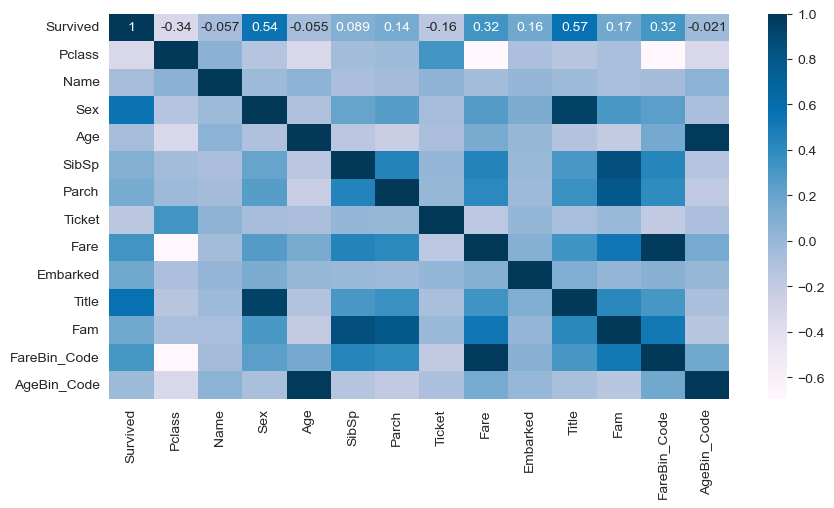

In [226]:
train_df = (entire_df.iloc[0:891][['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Title', 'Fam', 'FareBin_Code','AgeBin_Code']]).copy()
corr_matrix = train_df.corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True, cmap='PuBu')

In [123]:
## as we can see bins not so much helpfull, we can drop it

Random Forest:
  Accuracy (Train): 99.16%
  Accuracy (Test): 82.12%
  Log Loss (Train): 0.1025
  Log Loss (Test): 0.8213
--------------------------------------------------
SGD:
  Accuracy (Train): 82.44%
  Accuracy (Test): 76.54%
  Log Loss (Train): 0.4236
  Log Loss (Test): 0.4504
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 82.30%
  Accuracy (Test): 79.89%
  Log Loss (Train): 4.2191
  Log Loss (Test): 4.5212
--------------------------------------------------
KNN:
  Accuracy (Train): 85.96%
  Accuracy (Test): 82.68%
  Log Loss (Train): 0.2904
  Log Loss (Test): 1.3285
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 78.37%
  Accuracy (Test): 77.09%
  Log Loss (Train): 0.7984
  Log Loss (Test): 0.7539
--------------------------------------------------
SVC:
  Accuracy (Train): 83.57%
  Accuracy (Test): 82.12%
  Log Loss (Train): 0.4051
  Log Loss (Test): 0.4521
---------------------------------------------

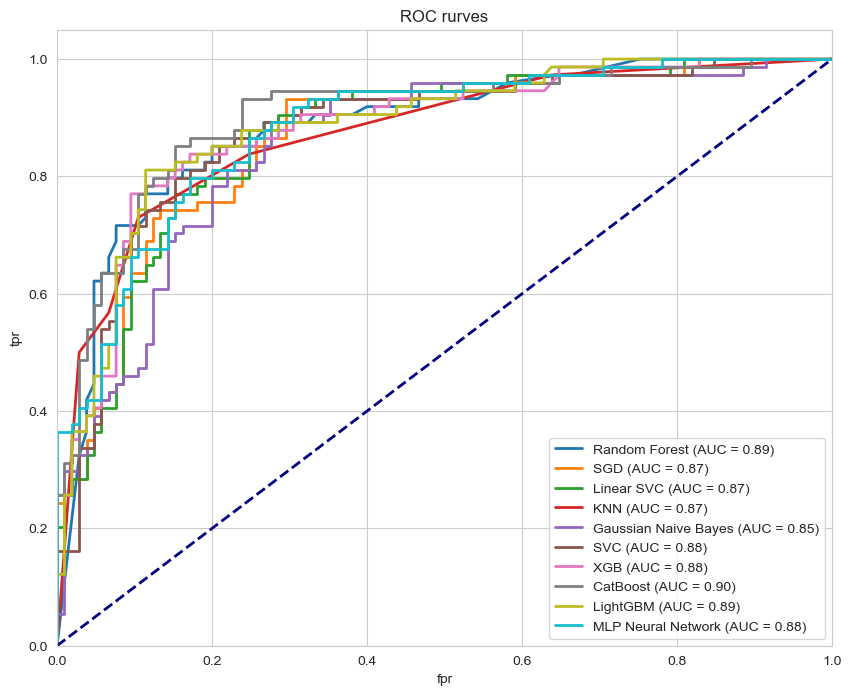

In [231]:
## lets evaluate validation sample

X = train_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
y = train_df['Survived']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)  
class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = y_train
        self.X_test = X_valid
        self.Y_test = y_valid
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, y_train, X_valid, y_valid)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

In [281]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

def calculate_log_loss(model, X_train, y_train, X_valid, y_valid):
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train)
        probas_test = model.predict_proba(X_valid)
    else:
        probas_train = model.decision_function(X_train)
        probas_test = model.decision_function(X_valid)

    log_loss_train = log_loss(y_train, probas_train)
    log_loss_test = log_loss(y_valid, probas_test)
    return log_loss_train, log_loss_test

# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, y_train)
        
        # Accuracy
        acc_train = accuracy_score(y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(y_valid, model.predict(X_valid)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, y_train, X_valid, y_valid)
        
        # Precision
        precision_train = precision_score(y_train, model.predict(X_train))
        precision_test = precision_score(y_valid, model.predict(X_valid))
        
        # Recall
        recall_train = recall_score(y_train, model.predict(X_train))
        recall_test = recall_score(y_valid, model.predict(X_valid))
        
        # F1-Score
        f1_train = f1_score(y_train, model.predict(X_train))
        f1_test = f1_score(y_valid, model.predict(X_valid))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        else:
            roc_auc_train = roc_auc_score(y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(y_valid, model.decision_function(X_valid))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='F1_test', ascending=False)
models_comparison






,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
0,Random Forest,99.326599,100.000000,0.099147,0.086172,0.991228,1.000000,0.991228,1.000000,0.991228,1.000000,0.999164,1.000000
6,XGB,96.296296,96.648045,0.122308,0.108011,0.978328,0.985714,0.923977,0.932432,0.950376,0.958333,0.996248,0.997683
8,LightGBM,94.388328,94.413408,0.148799,0.138482,0.956250,0.957143,0.894737,0.905405,0.924471,0.930556,0.992336,0.994144
7,CatBoost,91.694725,91.061453,0.265259,0.269246,0.924051,0.891892,0.853801,0.891892,0.887538,0.891892,0.957544,0.957722
3,KNN,86.644220,86.592179,0.284335,0.274883,0.865574,0.847222,0.771930,0.824324,0.816074,0.835616,0.936442,0.944530
5,SVC,83.389450,82.681564,0.414916,0.434578,0.825503,0.820896,0.719298,0.743243,0.768750,0.780142,0.886806,0.882368
9,MLP Neural Network,82.491582,79.888268,0.412948,0.412921,0.803922,0.771429,0.719298,0.729730,0.759259,0.750000,0.869097,0.889318
2,Linear SVC,81.593715,79.888268,4.363308,4.539231,0.794702,0.779412,0.701754,0.716216,0.745342,0.746479,0.864672,0.873616
1,SGD,81.818182,79.888268,0.437982,0.439342,0.833333,0.816667,0.657895,0.662162,0.735294,0.731343,0.864453,0.873488
4,Gaussian Naive Bayes,78.451178,77.094972,0.780397,0.733139,0.718023,0.726027,0.722222,0.716216,0.720117,0.721088,0.847437,0.854698


In [363]:
entire_df.iloc[891:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Fam,FareBin,FareBin_Code,AgeBin,AgeBin_Code
0,892,0,1.0,0.488515,0,34.5,0.000,0.000000,0.405172,0.015282,0.5,0.0,0.00,"(-0.001, 0.0153]",0,"(30.0, 39.0]",3
1,893,1,1.0,0.969372,1,47.0,0.125,0.000000,0.627155,0.013663,0.0,1.0,0.25,"(-0.001, 0.0153]",0,"(39.0, 80.0]",4
2,894,0,0.5,0.640888,0,62.0,0.000,0.000000,0.198276,0.018909,0.5,0.0,0.00,"(0.0153, 0.0205]",1,"(39.0, 80.0]",4
3,895,0,1.0,0.978560,0,27.0,0.000,0.000000,0.394397,0.016908,0.0,0.0,0.00,"(0.0153, 0.0205]",1,"(26.0, 30.0]",2
4,896,1,1.0,0.415773,1,22.0,0.125,0.111111,0.364224,0.023984,0.0,1.0,0.50,"(0.0205, 0.0421]",2,"(21.0, 26.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,1.0,0.862175,0,30.0,0.000,0.000000,0.766164,0.015713,0.0,0.0,0.00,"(0.0153, 0.0205]",1,"(26.0, 30.0]",2
414,1306,1,0.0,0.682236,1,39.0,0.000,0.000000,0.898707,0.212559,1.0,1.0,0.00,"(0.0812, 1.0]",4,"(30.0, 39.0]",3
415,1307,0,1.0,0.800919,0,38.5,0.000,0.000000,0.939655,0.014151,0.0,0.0,0.00,"(-0.001, 0.0153]",0,"(30.0, 39.0]",3
416,1308,0,1.0,0.939510,0,30.0,0.000,0.000000,0.623922,0.015713,0.0,0.0,0.00,"(0.0153, 0.0205]",1,"(26.0, 30.0]",2


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB
0.9234449760765551
0.8947368421052632
0.8947368421052632
0.8947368421052632
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       266
           1       0.89      0.89      0.89       152

    accuracy                           0.92       418
   macro avg       0.92      0.92      0.92       418
weighted avg       0.92      0.92      0.92       418

Confusion Matrix of Orginal model:


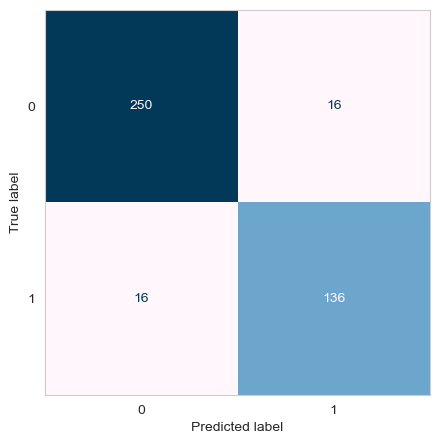

In [295]:
m = models[5][1]

test_df = entire_df.iloc[891:]
test_df = test_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
test_y = entire_df.iloc[891:, 1]


prediction = m.predict(test_df)

submission = pd.DataFrame(entire_df.iloc[891:]['PassengerId'], columns=['PassengerId'])
submission['Survived'] = prediction

submission.info()
test_y = entire_df.iloc[891:, 1]

# Accuracy
print(accuracy_score(test_y, prediction))
# Precision
print(precision_score(test_y, prediction))
# Recall
print(recall_score(test_y, prediction))
# F1-Score
print(f1_score(test_y, prediction))


print(classification_report(test_y ,m.predict(test_df)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y, m.predict(test_df), colorbar = False, cmap = 'PuBu')
plt.grid(False)


In [275]:
submission.to_csv('sub_linear_svc.csv', index= False)

In [153]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

Best hyperparameters: {'C': 0.49346628085493494, 'gamma': 0.49511252556857643}
Best score: 0.7487240156128638
Accuracy: 0.9593301435406698
Precision: 0.9530201342281879
Recall: 0.9342105263157895
F1-Score: 0.9435215946843853
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       266
           1       0.95      0.93      0.94       152

    accuracy                           0.96       418
   macro avg       0.96      0.95      0.96       418
weighted avg       0.96      0.96      0.96       418

Confusion Matrix of Orginal model:


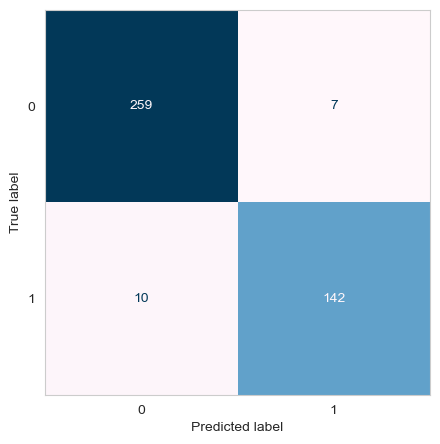

In [353]:
X_train = entire_df.iloc[0:891][['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']]
y_train = entire_df.iloc[0:891]['Survived']

from sklearn.model_selection import cross_val_score

def optuna_optimize(trial):
    param = {
        'C': trial.suggest_float('C', 1e-5, 0.5, log=True),
          'gamma': trial.suggest_float('gamma', 1e-5, 0.5, log=True)
    }
    model = SVC(**param)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(optuna_optimize, n_trials=1000)

print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)


best_params = study.best_params
final_model = SVC(**best_params)


final_model.fit(X_train, y_train)
predictions = final_model.predict(test_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']])


print("Accuracy:", accuracy_score(test_y, predictions))
print("Precision:", precision_score(test_y, predictions))
print("Recall:", recall_score(test_y, predictions))
print("F1-Score:", f1_score(test_y, predictions))


optuna.visualization.plot_param_importances(study)

print(classification_report(test_y ,predictions))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y,predictions, colorbar = False, cmap = 'PuBu')
plt.grid(False)

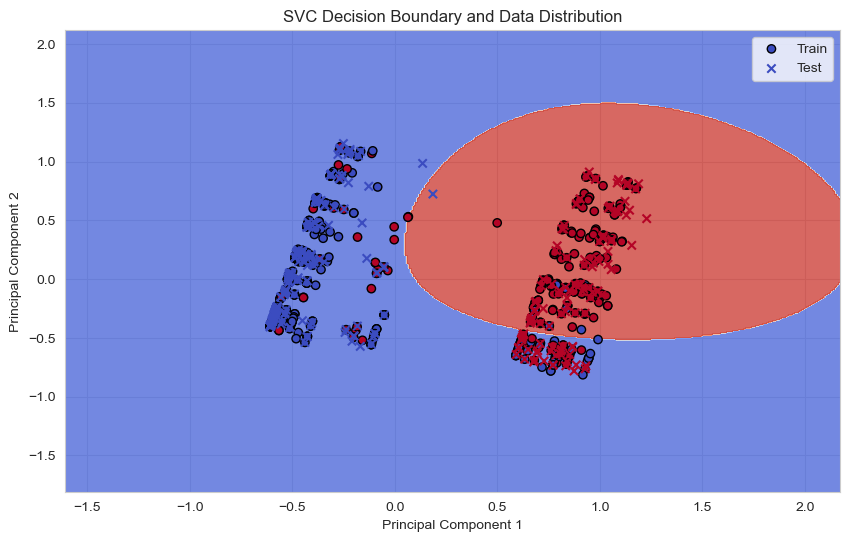

In [358]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(test_df[['Pclass', 'Sex', 'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']])


final_model = SVC(probability=True, gamma= 0.495, C = 0.495)
final_model.fit(X_train_pca, y_train)
predictions = final_model.predict(X_test_pca)


x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = final_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap='coolwarm', label='Train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_y, edgecolors='k', cmap='coolwarm', marker='x', label='Test')

plt.title("SVC Decision Boundary and Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

Accuracy: 0.9593301435406698
Precision: 0.9530201342281879
Recall: 0.9342105263157895
F1-Score: 0.9435215946843853
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       266
           1       0.95      0.93      0.94       152

    accuracy                           0.96       418
   macro avg       0.96      0.95      0.96       418
weighted avg       0.96      0.96      0.96       418

Confusion Matrix of Orginal model:


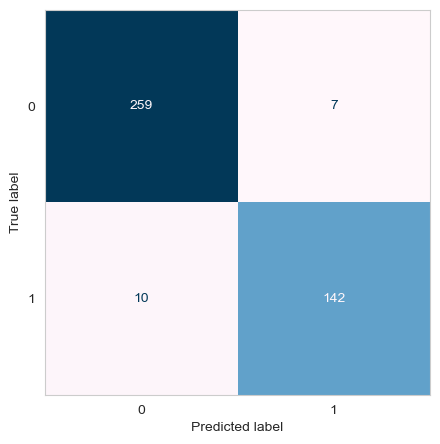

In [360]:
final_model.fit(X_train, y_train)
predictions = final_model.predict(test_df[['Pclass',  'Sex',  'Fare', 'Title', 'Fam', 'Embarked', 'Ticket']])

print("Accuracy:", accuracy_score(test_y, predictions))
print("Precision:", precision_score(test_y, predictions))
print("Recall:", recall_score(test_y, predictions))
print("F1-Score:", f1_score(test_y, predictions))


optuna.visualization.plot_param_importances(study)

print(classification_report(test_y ,predictions))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(test_y,predictions, colorbar = False, cmap = 'PuBu')
plt.grid(False)

In [359]:
submission = pd.DataFrame(entire_df.iloc[891:]['PassengerId'], columns=['PassengerId'])
submission['Survived'] = predictions

submission.to_csv('sub_svc_optimized_gamma.csv', index= False)